<a href="https://colab.research.google.com/github/dieguito1331/cienciaDatos/blob/master/posgrado/teoria/04 - regresion logistica - Metricas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Métricas ##
Un punto sumamente importante a la hora de construir un modelo es saber cómo lo vamos a medir. Muchas veces nos preocupamos por la información que vamos a utilizar, la cantidad de variables que vamos a crear, qué algoritmos vamos a utilizar y no prestamos demasiada atención en las métricas que vamos a usar a la hora de evaluar lo que estamos haciendo. Las métricas a utilizar las podemos dividir en dos grandes grupos, métricas propias de la creación de un modelo que nos indicarán que tan efectivo es el mismo y métricas del negocio que nos dirán si la solución propuesta responde al problema planteado por el negocio. Anteriormente comentaba que debemos conocer nuestro problema y nuestros datos para poder definir la métrica, y esto se debe a que podemos tener muchos factores que harán que tomemos decisiones con respecto a cómo medir nuestro trabajo. Un caso de esto es la posibilidad de tener bases muy "desbalanceadas" (cuando una base está desbalanceada, tenemos muchos casos de una clase y pocos de las restantes, un ejemplo de este punto son los modelos de attrition, en las que las bajas por mes son mucho menores que las personas que siguen siendo clientes)  

![join.JPG](https://www.aprendemachinelearning.com/wp-content/uploads/2019/05/confusion_matix_example.png)


**_Matriz de Confusión_**: Es una herramienta que nos permite observar el desempeño un algoritmo que se utiliza en aprendizaje supervisado. Las columnas de la matriz representa el número de predicciones de cada clase, y cada fila representa las observaciones reales de cada una de las clases. Una de las ventajas de las matrices de confusión es que nos facilitan ver si el sistema está confundiendo dos clases.  

**_Accuracy - Efectividad_**: La efectividad nos indica a cuantas observaciones le acerté a la hora de predecir su target. En otras palabras es el porcentaje de predicciones correctas sobre el total de observaciones. Como dijimos anteriormente, esta métrica funciona correctamente solamente si las clases están balanceadas, es decir, tienen la misma cantidad de sucesos todos los valores.
$$Accuracy = \frac{truePositive+trueNegative}{totalSamples}$$

**_precisión_**: Es el número de casos positivos correctamente predichos dividido la suma de todos los positivos predichos por el modelo. Nos dirá cúan confiable es un modelo en responder si una observación es de una clase determinada
$$precision = \frac{truePositives}{truePositives+falsePositives}$$

**_recall_**: Es el número de casos positivos correctamente predichos sobre el total de casos reales positivos (esto incluye los verdaderos positivos y falsos negativos). El recall nos dirá cúan bien puede el modelo detectar a una clase.
$$recall = \frac{truePositives}{truePositives+falseNegatives}$$

1) Si tenemos alta precisión y alto recall: podemos indicar que el modelo puede manejar perfectamente a esa clase.
2) Si tenemos alta precisión y bajo recall: el modelo no puede detectar muy bien la clase, pero si lo hace es totalmente confiable.
3) Si tenemos baja precisión y alto recall: el modelo detecta bien la clase


**_Curva ROC_**: La curva ROC (receiver operating characteristic curve) es un gráfico que nos ayuda a visualizar la performance de un modelo de clasificación en todos los umbrales de clasificación. Esta curva se dibuja gracias a dos parámetros:
* True Positive Rate (TPR): Es un sinónimo de recall y se define de la siguente forma: 
$$\frac {truePositives}{truePositives + falsePositives} $$
* False Positive Rates (FPR):
$$\frac{falsePositives}{falsePositives + trueNegatives} $$

La curva ROC grafica TPR vs. FPR para los diferentes puntos que podemos tomar como umbrales. Si bajamos el umbral, más items clasificaremos como positivos.


![join.JPG](https://developers.google.com/static/machine-learning/crash-course/images/ROCCurve.svg?hl=es-419
)
Para poder computar los puntos de la curva ROC, una forma es correr un modelo (por ejemplo una regresión logística, n veces, todas con un umbral diferente. No obstante, no es una forma eficiente de hacerlo. Para que podamos correr de forma eficiente esta métrica se utiliza un algoritmo que nos permite generar esta información, es el AUC.


**_AUC_**: Área debajo de la curva ROC (Area Under the ROC Curve), mide el área de completa de la curva. Desde (0,0) a (1,1). Integral de la curva


![join.JPG](https://developers.google.com/static/machine-learning/crash-course/images/AUC.svg?hl=es-419)



## Regresión logística en Python

### Importo y configuro lo necesario

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)#
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split##
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve

import matplotlib.pyplot as plt

from sklearn import tree
import os


### Levanto la base 

In [2]:
data = pd.read_csv("./Data/titanic_train.txt")
data = data.drop(columns = ["Cabin"])
data['titulo']=data['Name'].map(lambda x:x.split(',')[1].split('.')[0].strip())
tituloEdad = data[data.Age.isnull() == False].groupby("titulo").agg({"Age": "mean"}).reset_index()
tituloEdad = tituloEdad.rename(columns={"Age": "Age_Mean"})
data = pd.merge(data, tituloEdad, how="left", on="titulo")
data["Age"] = np.where((data.Age.isnull()) & (data.titulo != "Mr"), data.Age_Mean, data.Age)

medianAge = data[data.Age.isnull() == False].groupby(["Pclass", "Embarked"]).agg( {"Age": "median"}).reset_index().rename(columns = {"Age": "medianAge"})
data = pd.merge(data, medianAge, how="left", on = ["Pclass", "Embarked"])
data["Age"] = np.where(data.Age.isnull(), data.medianAge, data.Age)
data = data.drop(columns = ["medianAge", "Age_Mean"])

data["Embarked"] = np.where(data.Embarked.isnull(), data.Embarked.mode().values[0], data.Embarked)

medianAge = data.groupby("titulo").agg( {"Age": "median"}).reset_index().rename(columns = {"Age": "medianAge"})
data = pd.merge(data, medianAge, how="left", on = "titulo")
data["ageRatioTitle"] = data.Age / data.medianAge
data.drop(columns=["medianAge"], inplace = True)

data = data.join(pd.get_dummies(data["Embarked"]).astype(int))
data = data.join(pd.get_dummies(data["Sex"]).astype(int))
data.drop(columns=["Embarked", "titulo", "Ticket", "Name", "Sex"], inplace = True)

In [3]:
data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,ageRatioTitle,C,Q,S,female,male
0,1,0,3,22.0,1,0,7.2500,0.785714,0,0,1,0,1
1,2,1,1,38.0,1,0,71.2833,1.058550,1,0,0,1,0
2,3,1,3,26.0,0,0,7.9250,1.194086,0,0,1,1,0
3,4,1,1,35.0,1,0,53.1000,0.974981,0,0,1,1,0
4,5,0,3,35.0,0,0,8.0500,1.250000,0,0,1,0,1


In [8]:
X = data.drop(columns = ["PassengerId", "Survived"])
y = data.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=25)

In [9]:
print("Registros de la base de entrenamiento: {}, que es el {} de la base total".format(len(X_train), len(X_train)/len(X)))
print("Registros de la base de testeo: {}, que es el {} de la base total".format(len(X_test), len(X_test)/len(X)))

Registros de la base de entrenamiento: 623, que es el 0.6992143658810326 de la base total
Registros de la base de testeo: 268, que es el 0.30078563411896747 de la base total


### Entreno el modelo

In [10]:
#Instancio el modelo de regresión logística y utilizo el método fit para entrenar el modelo
treeModel = tree.DecisionTreeClassifier().fit(X_train, y_train)

In [11]:
treeModel

DecisionTreeClassifier()

### Obtengo las probabilidades
Con el modelo entrenado, obtengo las probabilidades de éxito (aquello que marqué cómo 1) de la base de test. Para ello uso la función predict_proba() del modelo creado

In [12]:
#Con esta linea obtengo una matriz en donde cada registro posee dos valores, la probabilidad de que sea el target 0 y 
#la probabilidad de que el target sea 1, la suma de ambas probabilidades siempre dará 100% (o el valor 1)
treeProbs = treeModel.predict_proba(X_test)
#De esta forma sólo nos quedamos con la probabilidad de éxito del modelo, o dicho de otra forma, de que el target de 1
treeProbs = treeProbs[:,-1]

## Métricas en Python

### Cálculo el accuracy del modelo [Documentación](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

In [14]:
#El accuracy del modelo es:
accuracy_score(y_test, treeProbs > 0.5)

0.8097014925373134

#### Ejercicio 1
En este caso, donde menos del 1% de los casos es target 1 (fallecidos), ¿está métrica es válida?

_Inserte aquí su respuesta_




### Cálculo de la matriz de confusión [Documentación](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [15]:
confusion_matrix(y_test, treeProbs > 0.5)

array([[137,  28],
       [ 23,  80]], dtype=int64)

In [21]:
confusion_matrix(y_test, treeProbs > 0.8)

array([[137,  28],
       [ 23,  80]], dtype=int64)

#### Ejercicio 2
Si modificamos el umbral, y lo ubicamos las cerca del 0 (por ejemplo en 0.1), ¿Qué pasará?

_Inserte aquí su respuesta_

### Cálculo del recall [Documentación](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)

In [27]:
recall_score(y_test, treeProbs > 0.1)

0.7864077669902912

### Cálculo de la precisión [Documentación](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)

In [34]:
precision_score(y_test, treeProbs > 0.5)

0.7407407407407407

### Construcción de la curva ROC

AUC [Documentación](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)  
ROC [Documentación](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)

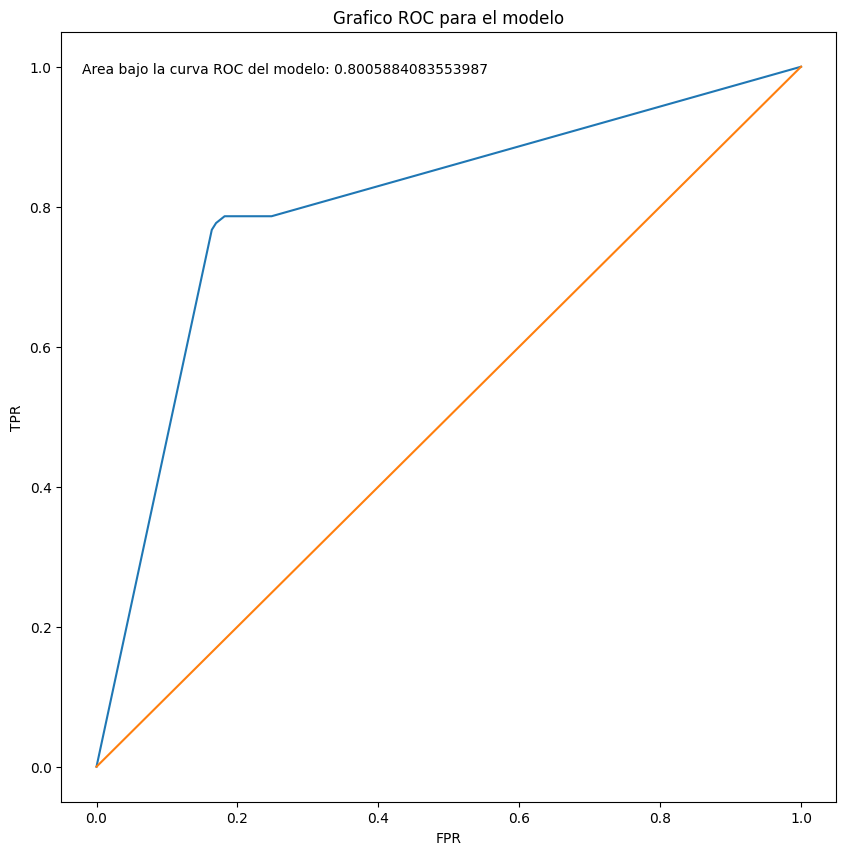

In [35]:
#De esta forma graficamos la curva ROC y calculamos el área debajo de la curva
areaBajoCurvaRoc = roc_auc_score(y_test, treeProbs)
fpr, tpr, _ = roc_curve(y_test, treeProbs)
plt.figure(figsize=(10,10))
plt.title("Grafico ROC para el modelo")
plt.plot(fpr, tpr)
plt.plot([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.annotate('Area bajo la curva ROC del modelo: {}'.format(areaBajoCurvaRoc), (-0.02,0.99))
plt.show()